# Grid algorithm for a logitnormal-binomial hierarchical model

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [4]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [5]:
from empiricaldist import Cdf

def compare_cdf(pmf, sample):
    pmf.make_cdf().plot(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

In [6]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [7]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [8]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [9]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

## Hospital Data with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [10]:
import pymc3 as pm
import theano.tensor as tt

def make_model():
    with pm.Model() as model:
        mu = pm.Normal('mu', 0, 2)
        sigma = pm.HalfNormal('sigma', sigma=1)
        xs = pm.LogitNormal('xs', mu=mu, sigma=sigma, shape=len(data_ns))
        ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    return model

CPU times: user 881 ms, sys: 71.1 ms, total: 952 ms
Wall time: 2.24 s


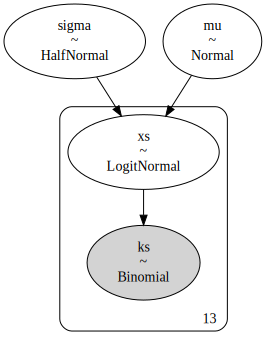

In [11]:
%time model = make_model()
pm.model_to_graphviz(model)

In [12]:
with model:
    pred = pm.sample_prior_predictive(1000)
    %time trace = pm.sample(500, target_accept=0.97)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9280282858677881, but should be close to 0.97. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 5.2 s, sys: 185 ms, total: 5.38 s
Wall time: 9.73 s


Here are the posterior distributions of the hyperparameters

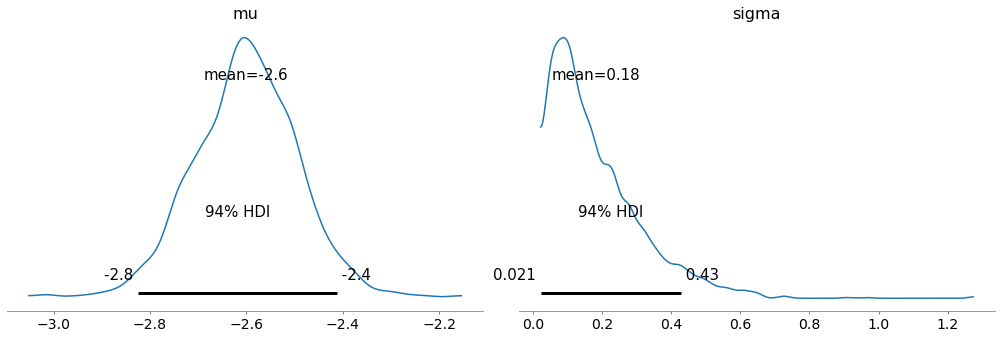

In [13]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['mu', 'sigma'])

And we can extract the posterior distributions of the xs.

In [14]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

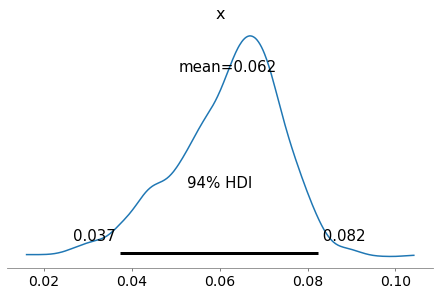

In [15]:
with model:
    az.plot_posterior(trace_xs[0])

## Just one update

In [16]:
i = 3
data_n = data_ns[i]
data_k = data_ks[i]

<AxesSubplot:>

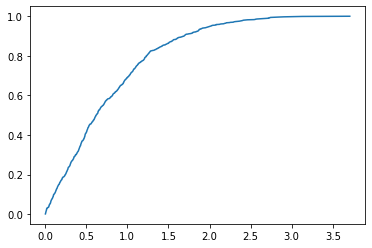

In [17]:
sample = pm.HalfNormal.dist().random(size=1000)
Cdf.from_seq(sample).plot()

In [18]:
def make_model1():
    with pm.Model() as model1:
        mu = pm.Normal('mu', 0, 2)
        sigma = pm.HalfNormal('sigma', sigma=1)
        x = pm.LogitNormal('x', mu=mu, sigma=sigma)
        k = pm.Binomial('k', n=data_n, p=x, observed=data_k)
    return model1

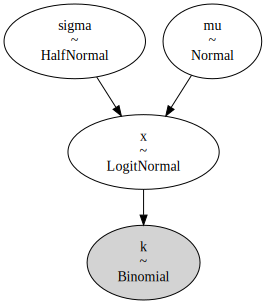

In [19]:
model1 = make_model1()
pm.model_to_graphviz(model1)

In [20]:
with model1:
    pred1 = pm.sample_prior_predictive(1000)
    trace1 = pm.sample(500, target_accept=0.97)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5361146921219951, but should be close to 0.97. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9360391707579205, but should be close to 0.97. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


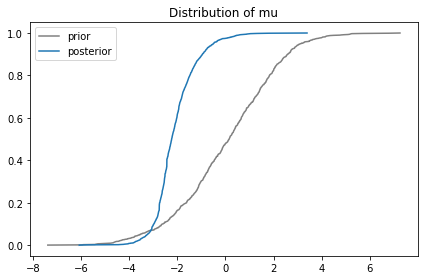

In [21]:
Cdf.from_seq(pred1['mu']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['mu']).plot(label='posterior')
decorate(title='Distribution of mu')

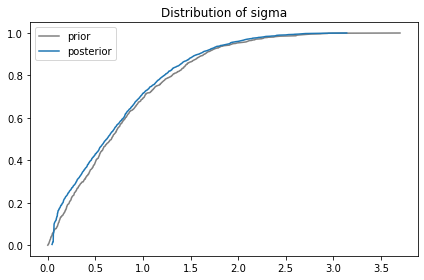

In [22]:
Cdf.from_seq(pred1['sigma']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['sigma']).plot(label='posterior')
decorate(title='Distribution of sigma')

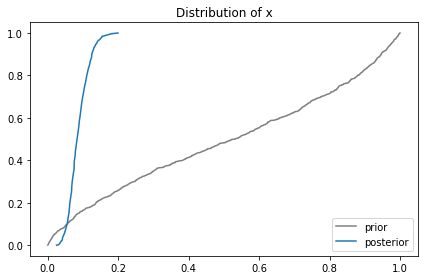

In [23]:
Cdf.from_seq(pred1['x']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['x']).plot(label='posterior')
decorate(title='Distribution of x')

## The grid priors

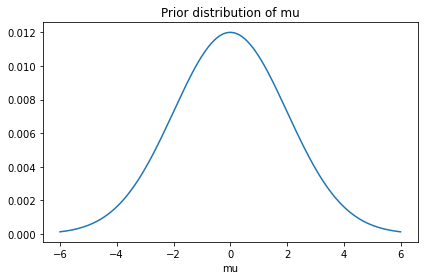

In [24]:
import numpy as np
from scipy.stats import norm

mus = np.linspace(-6, 6, 201)
ps = norm.pdf(mus, 0, 2)
prior_mu = make_pmf(ps, mus, 'mu')

prior_mu.plot()
decorate(title='Prior distribution of mu')

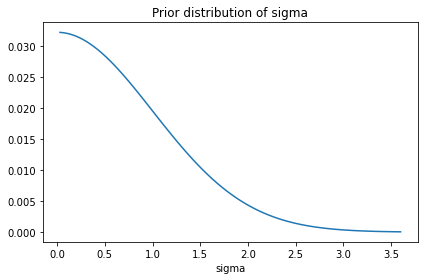

In [105]:
from scipy.stats import logistic

sigmas = np.linspace(0.03, 3.6, 90)
ps = norm.pdf(sigmas, 0, 1)
prior_sigma = make_pmf(ps, sigmas, 'sigma')

prior_sigma.plot()
decorate(title='Prior distribution of sigma')

-1.1102230246251565e-16 0.058920615604417595


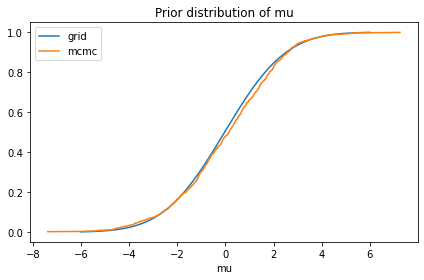

In [106]:
compare_cdf(prior_mu, pred1['mu'])
decorate(title='Prior distribution of mu')

0.8033718951689776 0.7863836350602794


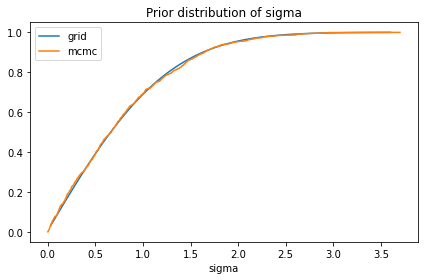

In [107]:
compare_cdf(prior_sigma, pred1['sigma'])
decorate(title='Prior distribution of sigma')

## The joint distribution of hyperparameters

In [108]:
# TODO: Change these variable names
def make_hyper(prior_alpha, prior_beta):
    PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')
    hyper = PA * PB
    return hyper

In [109]:
prior_hyper = make_hyper(prior_mu, prior_sigma)
prior_hyper.shape

(201, 90)

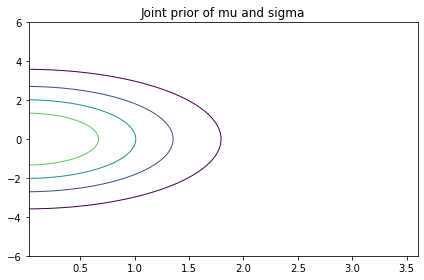

In [110]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(prior_hyper, index=mus, columns=sigmas))
decorate(title="Joint prior of mu and sigma")

## Joint prior of hyperparameters, and x

In [111]:
xs = np.linspace(0.01, 0.99, 99)
M, S, X = np.meshgrid(mus, sigmas, xs, indexing='ij')

In [112]:
from scipy.special import logit

LO = logit(X)
LO.sum()

2.1365664792938333e-10

In [113]:
from scipy.stats import beta as betadist

%time normpdf = norm.pdf(LO, M, S)
normpdf.sum()

CPU times: user 53.2 ms, sys: 8.55 ms, total: 61.8 ms
Wall time: 60.2 ms


143418.58755534427

We can speed this up by computing skipping the terms that don't depend on x

In [114]:
# TODO

In [115]:
totals = normpdf.sum(axis=2)
totals.sum()

143418.58755534427

In [116]:
shape = totals.shape + (1,)
totals = totals.reshape(shape)

out = np.zeros_like(normpdf)
normpdf = np.divide(normpdf, totals,
                    out=out, where=(totals!=0))
normpdf.sum()

18079.999999999996

In [117]:
def make_prior(hyper):

    # reshape hyper so we can multiply along axis 0
    shape = hyper.shape + (1,)
    prior = normpdf * hyper.reshape(shape)

    return prior

In [118]:
%time prior = make_prior(prior_hyper)
prior.sum()

CPU times: user 4.25 ms, sys: 123 µs, total: 4.37 ms
Wall time: 3.05 ms


0.9999482624648524

The following function computes the marginal distributions.

In [119]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

And let's confirm that the marginal distributions are what they are supposed to be.

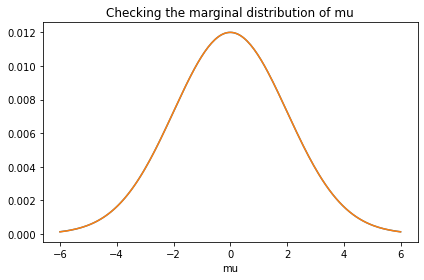

In [120]:
prior_mu.plot()
marginal_mu = Pmf(marginal(prior, 0), mus)
marginal_mu.plot()
decorate(title='Checking the marginal distribution of mu')

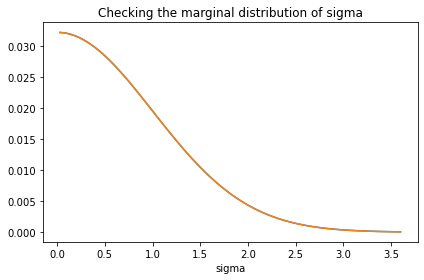

In [121]:
prior_sigma.plot()
marginal_sigma = Pmf(marginal(prior, 1), sigmas)
marginal_sigma.plot()
decorate(title='Checking the marginal distribution of sigma')

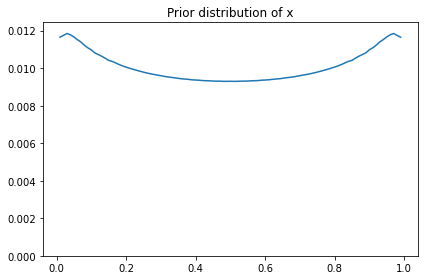

In [122]:
prior_x = Pmf(marginal(prior, 2), xs)
prior_x.plot()
decorate(title='Prior distribution of x',
        ylim=[0, prior_x.max()*1.05])

0.49997413123242573 0.5101368784087403


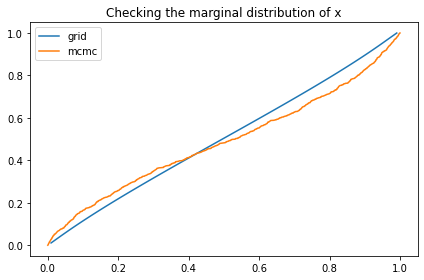

In [123]:
compare_cdf(prior_x, pred1['x'])
decorate(title='Checking the marginal distribution of x')

In [124]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [125]:
hyper = get_hyper(prior)

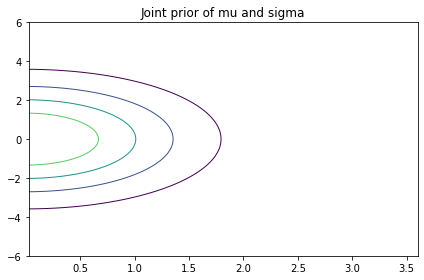

In [126]:
plot_contour(pd.DataFrame(hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Joint prior of mu and sigma")

## The Update

In [127]:
from scipy.stats import binom

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(99,)

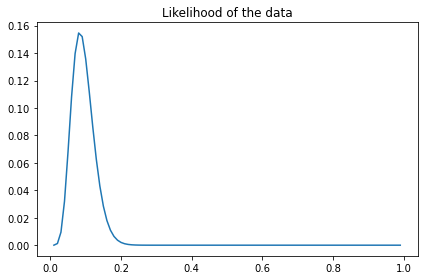

In [128]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

In [129]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)

    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [130]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 6.17 ms, sys: 1.26 ms, total: 7.42 ms
Wall time: 5.62 ms


-2.2839085822689538 -2.088863822436312


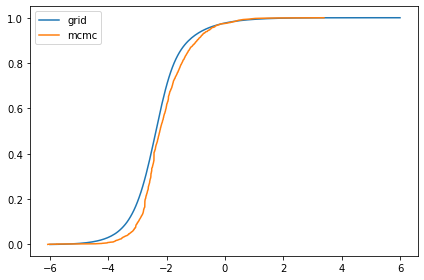

In [131]:
marginal_mu = Pmf(marginal(posterior, 0), mus)
compare_cdf(marginal_mu, trace1['mu'])

0.7427800571017901 0.7335328690237511


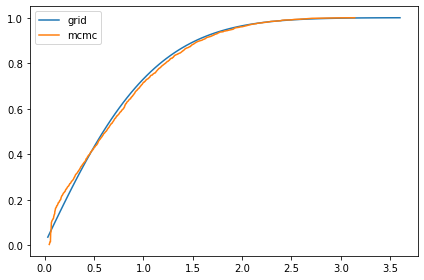

In [132]:
marginal_sigma = Pmf(marginal(posterior, 1), sigmas)
compare_cdf(marginal_sigma, trace1['sigma'])

0.09196221979589297 0.08762936641306768


(0.09196221979589297, 0.08762936641306768)

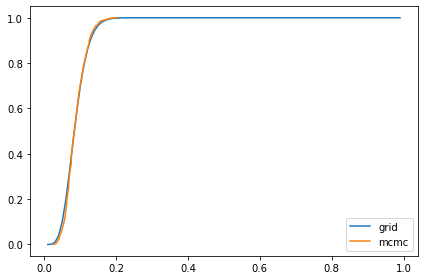

In [133]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace1['x'])
marginal_x.mean(), trace1['x'].mean()

In [134]:
posterior_hyper = get_hyper(posterior)

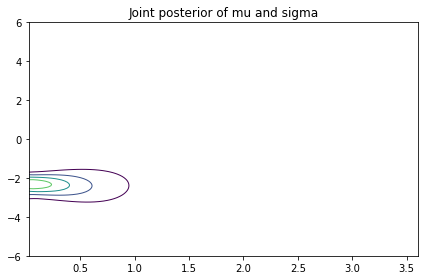

In [135]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Joint posterior of mu and sigma")

In [136]:
like_hyper = posterior_hyper / prior_hyper

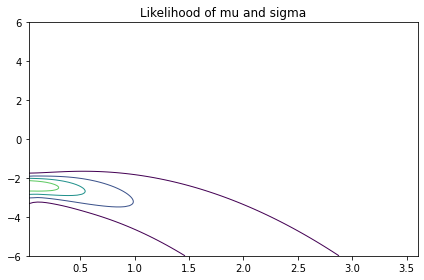

In [137]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Likelihood of mu and sigma")

## Multiple updates

In [138]:
prior = make_prior(prior_hyper)
prior.shape

(201, 90, 99)

In [139]:
def multiple_updates(prior, ns, ks, xs):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper)
    return posterior

In [140]:
%time posterior = multiple_updates(prior, data_ns, data_ks, xs)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 136 ms


-2.6467518480359096 -2.6015721172366684


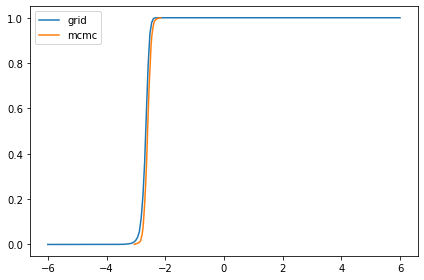

In [141]:
marginal_mu = Pmf(marginal(posterior, 0), mus)
compare_cdf(marginal_mu, trace['mu'])

0.1915112553021888 0.18254878851591824


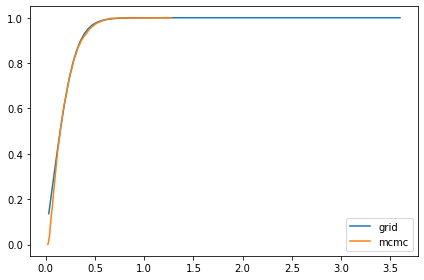

In [142]:
marginal_sigma = Pmf(marginal(posterior, 1), sigmas)
compare_cdf(marginal_sigma, trace['sigma'])

0.07337763229857364 0.07294535138274955


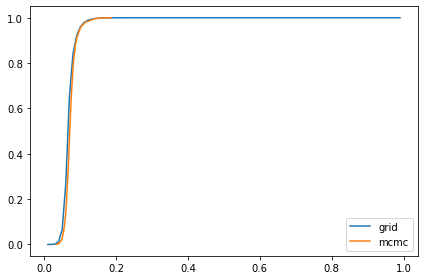

In [143]:
marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
compare_cdf(marginal_x, trace_xs[-1])

In [144]:
posterior_hyper = get_hyper(posterior)

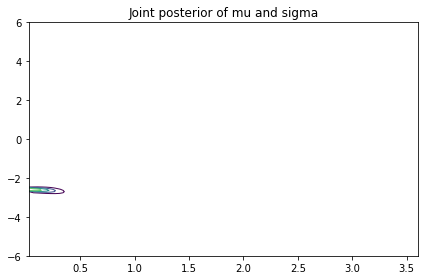

In [145]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Joint posterior of mu and sigma")

In [146]:
like_hyper = posterior_hyper / prior_hyper

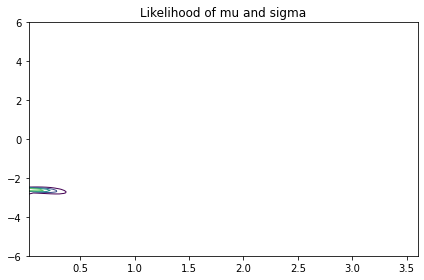

In [147]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Likelihood of mu and sigma")

## One at a time

In [148]:
def compute_likes_hyper(ns, ks):
    shape = ns.shape + mus.shape + sigmas.shape
    likes_hyper = np.empty(shape)
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        like_x = binom.pmf(k, n, xs)
        posterior = normpdf * like_x
        likes_hyper[i] = posterior.sum(axis=2)
        print(likes_hyper[i].sum())
    return likes_hyper

In [149]:
%time likes_hyper = compute_likes_hyper(data_ns, data_ks)

(129, 4)
274.6636874928713
(35, 1)
947.3342168409214
(228, 18)
94.69814128862927
(84, 7)
248.83063630089848
(291, 24)
72.82847873198654
(270, 16)
91.66869577666596
(46, 6)
375.4942185566961
(293, 19)
80.87855004218346
(241, 15)
100.20080616305229
(105, 13)
169.5205275044766
(353, 25)
64.42584485648294
(250, 11)
115.30877435625138
(41, 4)
470.80922741036693
CPU times: user 62.5 ms, sys: 2.83 ms, total: 65.4 ms
Wall time: 60.8 ms


In [150]:
likes_hyper.sum()

3106.661805321483

In [151]:
like_hyper_all = likes_hyper.prod(axis=0)
like_hyper_all.sum()

3.386435404797562e-14

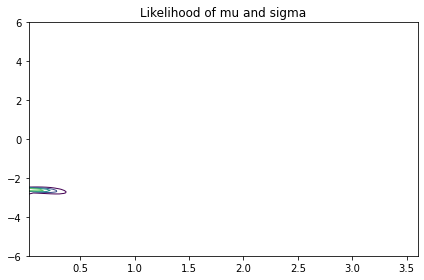

In [152]:
plot_contour(pd.DataFrame(like_hyper_all, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Likelihood of mu and sigma")

In [153]:
posterior_hyper_all = prior_hyper * like_hyper_all
posterior_hyper_all /= posterior_hyper_all.sum()

np.allclose(posterior_hyper_all, posterior_hyper)

True

True

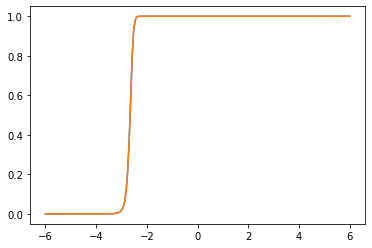

In [154]:
marginal_mu2 = Pmf(posterior_hyper_all.sum(axis=1), mus)
marginal_mu2.make_cdf().plot()
marginal_mu.make_cdf().plot()
np.allclose(marginal_mu, marginal_mu2)

True

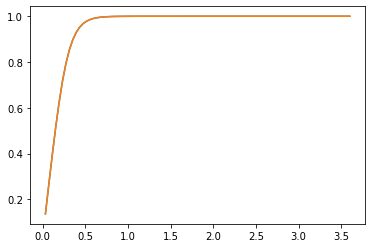

In [155]:
marginal_sigma2 = Pmf(posterior_hyper_all.sum(axis=0), sigmas)
marginal_sigma2.make_cdf().plot()
marginal_sigma.make_cdf().plot()
np.allclose(marginal_sigma, marginal_sigma2)

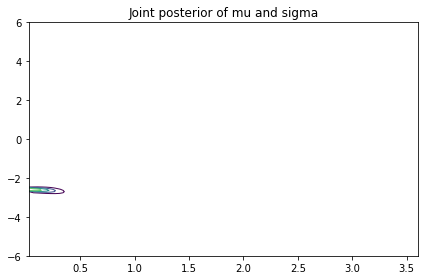

In [156]:
plot_contour(pd.DataFrame(posterior_hyper_all, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Joint posterior of mu and sigma")

In [157]:
i = 3
data = data_ns[i], data_ks[i]
data

(84, 7)

In [161]:
out = np.zeros_like(prior_hyper)
hyper_i = np.divide(prior_hyper * like_hyper_all, likes_hyper[i],
                    out=out, where=(like_hyper_all!=0))
hyper_i.sum()

4.3498768007097106e-17

In [162]:
prior_i = make_prior(hyper_i) 

In [163]:
posterior_i = update(prior_i, data)

<AxesSubplot:>

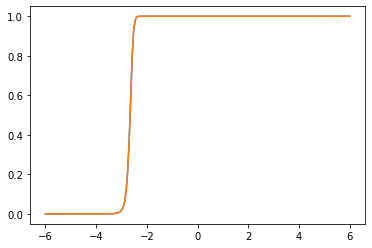

In [164]:
Pmf(marginal(posterior_i, 0), mus).make_cdf().plot()
marginal_mu.make_cdf().plot()

<AxesSubplot:>

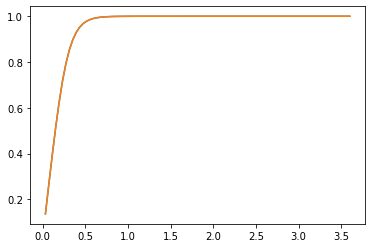

In [165]:
Pmf(marginal(posterior_i, 1), sigmas).make_cdf().plot()
marginal_sigma.make_cdf().plot()

In [166]:
marginal_mu = Pmf(marginal(posterior_i, 0), mus)
marginal_sigma = Pmf(marginal(posterior_i, 1), sigmas)
marginal_x = Pmf(marginal(posterior_i, 2), xs)

-2.6467518480359087 -2.6015721172366684


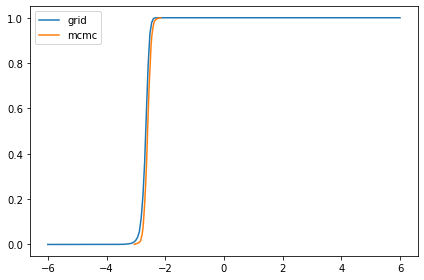

In [167]:
compare_cdf(marginal_mu, trace['mu'])

0.19151125530218874 0.18254878851591824


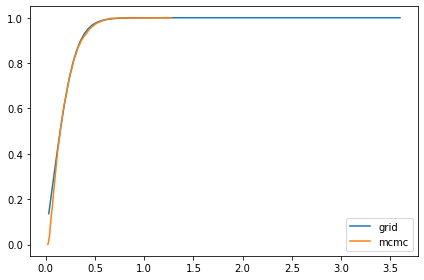

In [168]:
compare_cdf(marginal_sigma, trace['sigma'])

0.07252787840957128 0.07204467292400059


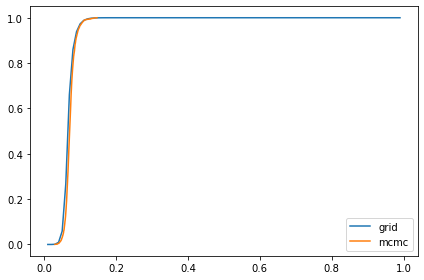

In [169]:
compare_cdf(marginal_x, trace_xs[i])

In [170]:
def compute_all_marginals(ns, ks):
    prior = prior_hyper * like_hyper_all
    
    for i, data in enumerate(zip(ns, ks)):
        n, k = data
        out = np.zeros_like(prior)
        hyper_i = np.divide(prior, likes_hyper[i], 
                            out=out, where=(prior!=0))
        prior_i = make_prior(hyper_i) 
        posterior_i = update(prior_i, data)
        marginal_x = Pmf(marginal(posterior_i, 2), xs)
        marginal_x.make_cdf().plot()
        print(i, n, k/n, marginal_x.mean())

In [171]:
for hyper_i in likes_hyper:
    print(i, (hyper_i==0).sum())

3 10
3 10
3 86
3 10
3 122
3 121
3 10
3 131
3 97
3 10
3 154
3 114
3 10


0 129 0.031007751937984496 0.06137958653648906
1 35 0.02857142857142857 0.06664479974857614
2 228 0.07894736842105263 0.07274237049843928
3 84 0.08333333333333333 0.07252787840957128
4 291 0.08247422680412371 0.07436258897925768
5 270 0.05925925925925926 0.06616799860643609
6 46 0.13043478260869565 0.07778708222589173
7 293 0.06484641638225255 0.06797709854830382
8 241 0.06224066390041494 0.06733148226794133
9 105 0.12380952380952381 0.08185537453928823
10 353 0.0708215297450425 0.07011480915344975
11 250 0.044 0.06149989077759829
12 41 0.0975609756097561 0.07337763229857365
CPU times: user 246 ms, sys: 168 ms, total: 413 ms
Wall time: 212 ms


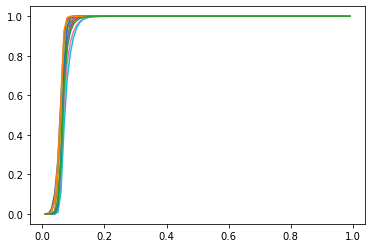

In [172]:
%time compute_all_marginals(data_ns, data_ks)